In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

## Generate Testing Data

In [274]:
np.random.seed(42)
n_samples = int( 10e3 )
df = pd.DataFrame({
    'x1': 5 + np.random.randn(n_samples) * 2,
    'x2': 10 + np.random.randn(n_samples) * 2,
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = 2 * np.cos(df['x1']) + 3 * np.sin(df['x2']) + np.random.randn(n_samples) * 1 + np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

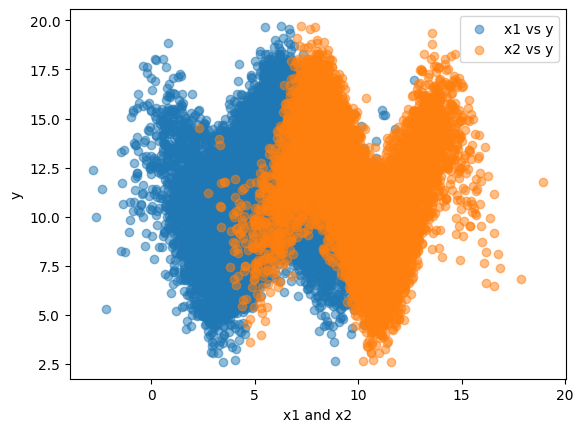

In [275]:
plt.scatter(df['x1'], df['y'], alpha=0.5, label='x1 vs y')
plt.scatter(df['x2'], df['y'], alpha=0.5, label='x2 vs y')
plt.xlabel('x1 and x2')
plt.ylabel('y')
plt.legend()

## Naive Linear Model

In [304]:

model = smf.ols('y ~ x1 + x2 + C(x3)', data=df).fit()

In [305]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     479.5
Date:                Mon, 04 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:49:51   Log-Likelihood:                -23947.
No. Observations:               10000   AIC:                         4.790e+04
Df Residuals:                    9995   BIC:                         4.794e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8931      0.158     75.427      0.000      11.584      12.202
C(x3)[T.1]     1.0054      0.075     13.451      0.000       0.859       1.152
C(x3)[T.2]     1.9968      0.065     30.849      0.000       1.870       2.124
x1             0.2460      0.013     18.598      0.000       0.220       0.272
x2            -0.3274      0.013    -24.695      0.000      -0.353      -0.301
==============================================================================
Omnibus:                      165.849   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.873
Skew:                           0.078   Prob(JB):                     2.06e-22
Kurtosis:                       2.536   Cond. No.                         69.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

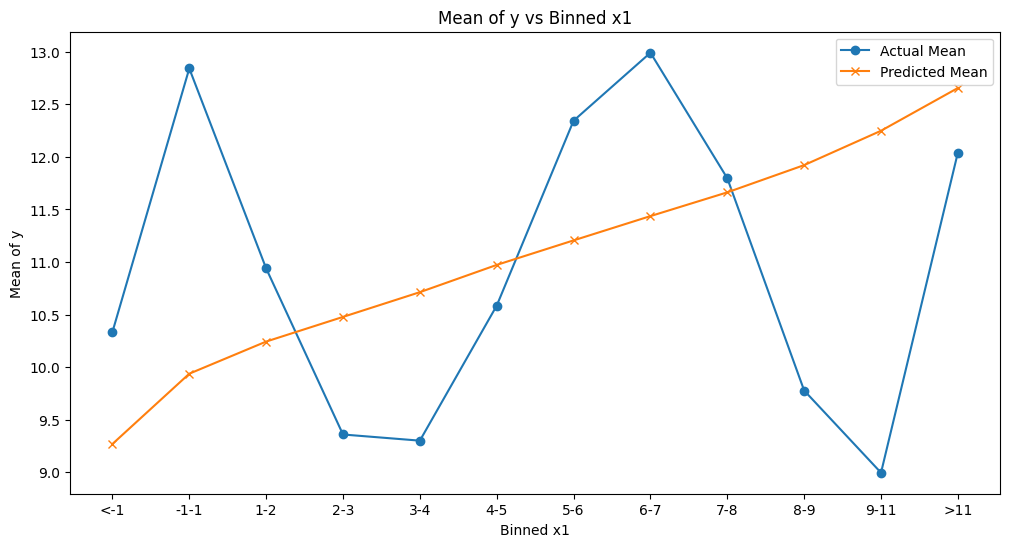

In [306]:
from quantbullet.dfutils import get_bins_and_labels

bins, labels = get_bins_and_labels( cutoffs=[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
df['x1_binned'] = pd.cut(df['x1'], bins=bins, labels=labels)
df['ols_predicted'] = model.predict(df)

summary = df.groupby('x1_binned', observed=True).agg({'y': 'mean', 'ols_predicted': 'mean'})
plt.figure(figsize=(12, 6))
plt.plot(summary.index, summary['y'], marker='o', label='Actual Mean')
plt.plot(summary.index, summary['ols_predicted'], marker='x', label='Predicted Mean')
plt.xlabel('Binned x1')
plt.ylabel('Mean of y')
plt.title('Mean of y vs Binned x1')
plt.legend()

In [307]:
0.5 * np.sum ( np.power( df['ols_predicted'] - df['y'], 2 ) )

35195.568514316794

## Multiplicative Model

In [280]:
from quantbullet.preprocessing.transformers import FlatRampTransformer
from numpy.linalg import lstsq

In [281]:
x1_trans = FlatRampTransformer(
    knots = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    include_bias=True
)

In [282]:
train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() + x2_trans.get_feature_names_out().tolist())

In [283]:
0.5 * np.sum( np.power( df['y'] -df['y'].mean() , 2 ) )

41948.87316402558

In [284]:
v =  train_df.values @ ( np.ones( train_df.shape[1] ) * 0.1 )
0.5 * np.sum( np.power( v - df['y'], 2 ) )

296286.8290551243

In [285]:
solving_params, *_ = lstsq(train_df.values, df['y'], rcond=None)

In [286]:
df['ols_piecewise_predicted'] = train_df.values @ solving_params
0.5 * np.sum( np.power( df['ols_piecewise_predicted'] - df['y'], 2 ) )

10032.815135491726

In [287]:

feature_sets = {'x1': x1_trans.get_feature_names_out().tolist(), 'x2': x2_trans.get_feature_names_out().tolist() }
initial_params = { feature_set : np.zeros( len( feature_names ) ) for feature_set, feature_names in feature_sets.items() }
num_iterations = 10

In [288]:
solving_params_x1, *_ = lstsq(train_df[ feature_sets['x1'] ].values, df['y'], rcond=None)
df['ols_x1_predicted'] = train_df[ feature_sets['x1'] ].values @ solving_params_x1
solving_params_x2, *_ = lstsq(train_df[ feature_sets['x2'] ].values, df['y'], rcond=None)
df['ols_x2_predicted'] = train_df[ feature_sets['x2'] ].values @ solving_params_x2

0.5 * np.sum( np.power( df['ols_x1_predicted'] - df['y'], 2 ) )
0.5 * np.sum( np.power( df['ols_x2_predicted'] - df['y'], 2 ) )

19925.39717559205

In [289]:

feature_sets = {'x1': x1_trans.get_feature_names_out().tolist(), 'x2': x2_trans.get_feature_names_out().tolist() }
initial_params = { feature_set : np.zeros( len( feature_names ) ) for feature_set, feature_names in feature_sets.items() }
num_iterations = 10

for i in range(num_iterations):
    for solving_set in feature_sets:
        print(f"Solving for feature set: {solving_set}")

        solving_y = df['y'].values.copy()

        # subtract other contributions
        for fixed_set in feature_sets:
            if fixed_set == solving_set:
                continue
            inner = train_df[feature_sets[fixed_set]].values @ initial_params[fixed_set]
            inner = np.clip(inner, 1e-1, None)
            solving_y -= np.log(inner)

        # linearize
        solving_x = train_df[feature_sets[solving_set]].values
        solving_y = np.exp(solving_y)

        # stable OLS
        solving_params, *_ = lstsq(solving_x, solving_y, rcond=None)
        initial_params[solving_set] = solving_params

        print(f"Updated parameters for {solving_set}: {initial_params[solving_set]}")

    # compute model predictions with all params
    y_hat = np.zeros(len(df))
    for fs in feature_sets:
        inner = train_df[feature_sets[fs]].values @ initial_params[fs]
        inner = np.clip(inner, 1e-8, None)
        y_hat += np.log(inner)

    cost = 0.5 * np.sum((y_hat - df['y'].values) ** 2)
    print(f"Iteration {i+1}, Cost: {cost}")


Solving for feature set: x1
Updated parameters for x1: [-3.59499808e+08  3.77202231e+07 -9.46381846e+06 -2.84018874e+07
  9.23161835e+05  1.00988983e+06  7.00237237e+06  5.04524130e+07
 -1.62551460e+07 -4.57737228e+07  5.73811351e+06 -2.06496748e+06
  5.17374828e+07]
Solving for feature set: x2
Updated parameters for x2: [ 519491.35241505   50896.84209707 -212007.82997096  641195.09179533
 -177697.27378339 -225112.55102677  -93822.56395597    9101.63563914
   16028.6608238   -52744.36020891  728864.13385299 -375133.96696441
 -231333.58197819]
Iteration 1, Cost: 1137657.4563706417
Solving for feature set: x1
Updated parameters for x1: [ 7147079.23682068  2247382.81776648  -930876.4949793   -924586.00676557
    72466.21150568    49136.33797286    47289.04947724  1879330.76225222
  -426425.95555482 -1797119.91769864   314732.15943792   -15548.83345147
    65748.16433932]
Solving for feature set: x2
Updated parameters for x2: [  20880.27698235   56096.82297943 -237647.27948757  779787.3904

## Optimize globally with `least_squares`

In [316]:
import numpy as np

def model(params, X_blocks):
    """
    params: concatenated parameter vector for all blocks
    X_blocks: list of (X, n_features)
    """
    n = X_blocks[0][0].shape[0]
    y_hat = np.zeros(n)
    idx = 0
    for X, n_feat in X_blocks:
        theta = params[idx: idx+n_feat]
        idx += n_feat
        inner = X @ theta
        # enforce positivity inside log
        inner = np.clip(inner, 1e-8, None)
        y_hat += np.log(inner)
    return y_hat

def residuals(params, X_blocks, y):
    y_hat = model(params, X_blocks)
    return y_hat - y

from scipy.optimize import least_squares

# Example: two blocks x1, x2
X1 = train_df[feature_sets['x1']].values
X2 = train_df[feature_sets['x2']].values

X_blocks = [(X1, X1.shape[1]), (X2, X2.shape[1])]
y = df['y'].values

# initial guess (all 1’s)
init_params = np.ones(sum(n for _, n in X_blocks))

res = least_squares(
    residuals,
    init_params,
    args=(X_blocks, y),
    method="trf",        # trust region reflective
    loss="linear",       # can try "huber" if outliers
    verbose=2,
    ftol=1e-6
)

print("Success:", res.success)
print("Optimal params:", res.x)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5533e+04                                    3.90e+03    
       1              2         4.4493e+04      2.10e+04       5.10e+00       6.06e+02    
       2              3         4.1463e+04      3.03e+03       1.02e+01       5.58e+01    
       3              4         4.0345e+04      1.12e+03       2.04e+01       1.24e+02    
       4              6         3.9258e+04      1.09e+03       1.02e+01       1.90e+02    
       5              7         3.8319e+04      9.39e+02       2.04e+01       1.21e+04    
       6              8         3.5193e+04      3.13e+03       2.04e+01       1.50e+03    
       7              9         3.3290e+04      1.90e+03       4.08e+01       1.31e+03    
       8             12         3.2960e+04      3.30e+02       5.10e+00       1.15e+02    
       9             14         3.2820e+04      1.41e+02       2.55e+00       6.89e+01    

In [317]:
train_df['non_linear_pred'] = model(res.x, X_blocks)

In [318]:
train_df['non_linear_pred']

0       15.336451
1       11.409282
2       14.793773
3        8.328732
4       10.829517
          ...    
9995     9.179046
9996    12.460692
9997     6.747348
9998    15.351330
9999    14.421200
Name: non_linear_pred, Length: 10000, dtype: float64

In [319]:
df['non_linear_pred'] = model(res.x, X_blocks)

In [320]:
0.5 * np.sum ( np.power( df['non_linear_pred'] - df['y'], 2 ) )

10632.816917836717

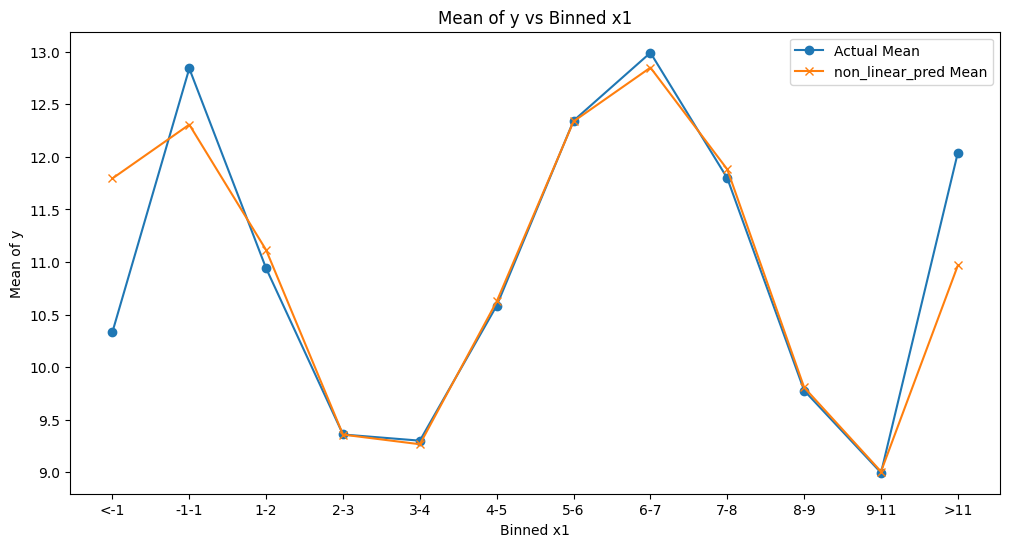

In [321]:
from quantbullet.dfutils import get_bins_and_labels

summary = df.groupby('x1_binned', observed=True).agg({'y': 'mean', 'non_linear_pred': 'mean'})
plt.figure(figsize=(12, 6))
plt.plot(summary.index, summary['y'], marker='o', label='Actual Mean')
plt.plot(summary.index, summary['non_linear_pred'], marker='x', label='non_linear_pred Mean')
plt.xlabel('Binned x1')
plt.ylabel('Mean of y')
plt.title('Mean of y vs Binned x1')
plt.legend()

In [322]:
res.x

array([-1.24008549e+06,  2.05309777e+07, -1.23915889e+07, -1.27150418e+07,
       -1.25527876e+06,  6.83116799e+05,  6.82831535e+06,  3.53583667e+07,
       -1.44785232e+07, -2.59321779e+07, -2.62241501e+06,  9.33554191e+05,
        1.26299775e+07,  3.66258878e-01, -1.27700676e-03,  2.65759602e-03,
        5.69701232e-02,  1.95465337e-01, -2.33457701e-01, -2.05456201e-02,
       -1.12394643e-03,  1.17818901e-03,  2.11092077e-02,  1.97796679e-01,
       -1.71065323e-01, -3.07761724e-02])

## Using Pytorch

## Torch

In [350]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert data to torch tensors
X_blocks = []
for fs in feature_sets:
    X = torch.tensor(train_df[feature_sets[fs]].values, dtype=torch.float32)
    X_blocks.append(X)

y = torch.tensor(df['y'].values, dtype=torch.float32)

# Define model parameters (one tensor per block)
params = []
for fs in feature_sets:
    n_features = len(feature_sets[fs])
    theta = nn.Parameter(torch.ones(n_features))
    params.append(theta)

# Put parameters into an optimizer
optimizer = optim.LBFGS(params, lr=1e-4, max_iter=100)  # or Adam for large data

# Forward function
def forward():
    y_hat = torch.zeros_like(y)
    for X, theta in zip(X_blocks, params):
        inner = X @ theta
        inner = torch.clamp(inner, min=1e-8)   # avoid log domain errors
        y_hat += torch.log(inner)
    return y_hat

# Loss function = MSE
loss_fn = nn.MSELoss()


In [351]:
def closure():
    optimizer.zero_grad()
    y_hat = forward()
    loss = loss_fn(y_hat, y)
    loss.backward()
    return loss

# for epoch in range(500):
#     loss = optimizer.step(closure)
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

best_loss = float("inf")
best_params = None

for epoch in range(500):
    loss = optimizer.step(closure)   # LBFGS step calls closure internally
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

    # track best so far
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_params = [p.detach().clone() for p in params]

Epoch 1, Loss: 13.106525
Epoch 2, Loss: 13.061668
Epoch 3, Loss: 13.016368
Epoch 4, Loss: 12.970942
Epoch 5, Loss: 12.925093
Epoch 6, Loss: 12.878268
Epoch 7, Loss: 12.830283
Epoch 8, Loss: 12.782050
Epoch 9, Loss: 12.733860
Epoch 10, Loss: 12.685713
Epoch 11, Loss: 12.637607
Epoch 12, Loss: 12.589520
Epoch 13, Loss: 12.541466
Epoch 14, Loss: 12.493422
Epoch 15, Loss: 12.445391
Epoch 16, Loss: 12.397363
Epoch 17, Loss: 12.349337
Epoch 18, Loss: 12.301304
Epoch 19, Loss: 12.253270
Epoch 20, Loss: 12.205230
Epoch 21, Loss: 12.157170
Epoch 22, Loss: 12.109107
Epoch 23, Loss: 12.061027
Epoch 24, Loss: 12.012938
Epoch 25, Loss: 11.964850
Epoch 26, Loss: 11.916739
Epoch 27, Loss: 11.868635
Epoch 28, Loss: 11.820527
Epoch 29, Loss: 11.772413
Epoch 30, Loss: 11.724299
Epoch 31, Loss: 11.676203
Epoch 32, Loss: 11.628107
Epoch 33, Loss: 11.580025
Epoch 34, Loss: 11.531951
Epoch 35, Loss: 11.483898
Epoch 36, Loss: 11.435869
Epoch 37, Loss: 11.387841
Epoch 38, Loss: 11.339833
Epoch 39, Loss: 11.29

In [346]:
all_params = torch.cat([p.detach() for p in best_params]).cpu().numpy()
print("All params:", all_params)

All params: [   58.00649       4.5559897  -529.7939     -990.55054    -101.89295
    30.058332    519.22375    2006.2145     -582.56793   -1806.7689
  -206.81737      51.966328    721.1335     -103.60025     -34.97933
   116.4769     1555.7231      912.8703    -2267.0725     -292.85703
   -19.204224     28.790558    647.43024     890.47614    -856.6517
  -182.11406  ]


In [347]:
X1 = train_df[feature_sets['x1']].values
X2 = train_df[feature_sets['x2']].values

X_blocks = [(X1, X1.shape[1]), (X2, X2.shape[1])]

In [348]:
df['torch_linear_pred'] = model(all_params, X_blocks)

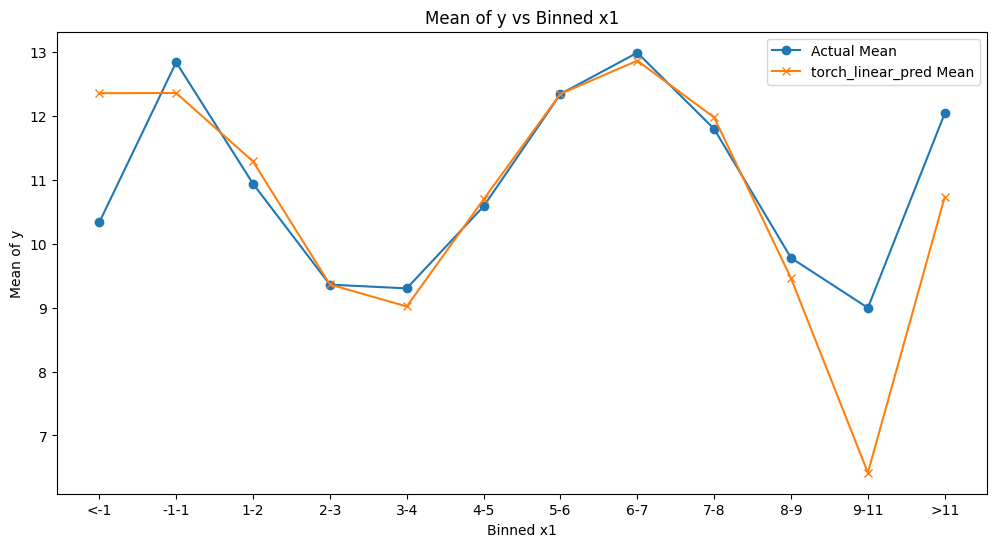

In [349]:
from quantbullet.dfutils import get_bins_and_labels

summary = df.groupby('x1_binned', observed=True).agg({'y': 'mean', 'torch_linear_pred': 'mean'})
plt.figure(figsize=(12, 6))
plt.plot(summary.index, summary['y'], marker='o', label='Actual Mean')
plt.plot(summary.index, summary['torch_linear_pred'], marker='x', label='torch_linear_pred Mean')
plt.xlabel('Binned x1')
plt.ylabel('Mean of y')
plt.title('Mean of y vs Binned x1')
plt.legend()